# Ultimate challenge - Prediction exercise


Ultimate is interested in predicting rider retention. To help explore this question, we have
provided a sample dataset of a cohort of users who signed up for an Ultimate account in
January 2014. The data was pulled several months later; we consider a user retained if they
were “active” (i.e. took a trip) in the preceding 30 days.
We would like you to use this data set to help understand what factors are the best predictors
for retention, and offer suggestions to operationalize those insights to help Ultimate.
The data is in the attached file ultimate_data_challenge.json. See below for a detailed
description of the dataset. Please include any code you wrote for the analysis and delete the
dataset when you have finished with the challenge.
1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided
data for this analysis (a few sentences/plots describing your approach will suffice). What
fraction of the observed users were retained?
2. Build a predictive model to help Ultimate determine whether or not a user will be active in
their 6th month on the system. Discuss why you chose your approach, what alternatives
you considered, and any concerns you have. How valid is your model? Include any key
indicators of model performance.
3. Briefly discuss how Ultimate might leverage the insights gained from the model to
improve its long term rider retention (again, a few sentences will suffice).

In [130]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.linear_model import LogisticRegression

In [131]:
# Opening JSON file
f = open('ultimate_data_challenge.json')
data = json.load(f)

In [132]:
df_raw=pd.DataFrame.from_dict(data)
df_raw.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [133]:
df_raw.describe().T

,count,mean,std,min,25%,50%,75%,max
trips_in_first_30_days,50000.0,2.278200,3.792684,0.0,0.00,1.00,3.00,125.00
avg_rating_of_driver,41878.0,4.601559,0.617338,1.0,4.30,4.90,5.00,5.00
avg_surge,50000.0,1.074764,0.222336,1.0,1.00,1.00,1.05,8.00
surge_pct,50000.0,8.849536,19.958811,0.0,0.00,0.00,8.60,100.00
weekday_pct,50000.0,60.926084,37.081503,0.0,33.30,66.70,100.00,100.00
avg_dist,50000.0,5.796827,5.707357,0.0,2.42,3.88,6.94,160.96
avg_rating_by_driver,49799.0,4.778158,0.446652,1.0,4.70,5.00,5.00,5.00


In [134]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [135]:
#transform string vars to dummies
phone=pd.get_dummies(df_raw.phone)
city=pd.get_dummies(df_raw.city)

In [136]:
df_raw.drop('phone', axis=1, inplace=True)
df_raw=df_raw.join(phone)

df_raw.drop('city', axis=1, inplace=True)
df_raw=df_raw.join(city)

Missing information for driver ratings.Impute with median.

In [137]:
from sklearn.impute import SimpleImputer
mv=df_raw[['avg_rating_by_driver', 'avg_rating_of_driver', 'Android', 'iPhone']]
imp = SimpleImputer(missing_values=np.nan, strategy='median')
imp.fit(mv)
SimpleImputer()
mv=pd.DataFrame(imp.transform(mv))


In [138]:
df=df_raw.drop(['avg_rating_by_driver', 'avg_rating_of_driver','Android', 'iPhone'], axis=1)
df['avg_rating_by_driver']=mv[0]
df['avg_rating_of_driver']=mv[1]
df['Android']=mv[2]
df['iPhone']=mv[3]

In [140]:
# make y = 1 if client was active
#boolean variable whether client was active in last 30 days
df['last_trip_date']=pd.to_datetime(df['last_trip_date'])
df['signup_date']=pd.to_datetime(df['signup_date'])
type(df.last_trip_date[1])

pandas._libs.tslibs.timestamps.Timestamp

In [141]:
#how to define last 30 days? we do not know when the data were generated.
#I assume max(last_trip_date) is the baseline date for counting 30 days backwards
import datetime
days = datetime.timedelta(30)
ref_date=max(df.last_trip_date)-days
print(max(df.last_trip_date),ref_date)

2014-07-01 00:00:00 2014-06-01 00:00:00


In [142]:
#y=1 if client took trip in last 30 d, 0 otherwise
y=pd.Series(df.last_trip_date>ref_date)

In [143]:
df.drop('last_trip_date', axis=1, inplace=True)

In [144]:
print("The share of retained clients is ", np.mean(y))

The share of retained clients is  0.3662


In [153]:
df['signup_date']=df['signup_date'].map(datetime.datetime.toordinal)

In [154]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   trips_in_first_30_days  50000 non-null  int64  
 1   signup_date             50000 non-null  int64  
 2   avg_surge               50000 non-null  float64
 3   surge_pct               50000 non-null  float64
 4   ultimate_black_user     50000 non-null  bool   
 5   weekday_pct             50000 non-null  float64
 6   avg_dist                50000 non-null  float64
 7   Astapor                 50000 non-null  uint8  
 8   King's Landing          50000 non-null  uint8  
 9   Winterfell              50000 non-null  uint8  
 10  avg_rating_by_driver    50000 non-null  float64
 11  avg_rating_of_driver    50000 non-null  float64
 12  Android                 50000 non-null  float64
 13  iPhone                  50000 non-null  float64
dtypes: bool(1), float64(8), int64(2), uint

## Modelling

### Simple logistic regression

In [155]:
def logistic_cv(X_train, X_test, y_train, y_test):
    C = [0.00001,0.0001, 0.001, 0.01, 0.1,1,10,100,1000, 10000]
    penalty = ['l2']
    parameters = dict(C=C, penalty=penalty)
    logistic=LogisticRegression(class_weight='balanced', max_iter=500)
    gsl=GridSearchCV(logistic, parameters, cv=3, n_jobs=-1, scoring="roc_auc")
    gsl.fit(X_train, y_train)
    return gsl


In [156]:
#fit tuned model
def fit_tuned_lr_model(model):    
    logisticCV=LogisticRegression(class_weight='balanced',C=model.best_params_['C'], penalty=model.best_params_['penalty'], max_iter=1000)
    logisticCV.fit(X_train, y_train)

    #return predicted probabilities
    lr_probs = logisticCV.predict_proba(X_test)

    # keep probabilities for the positive outcome only
    lr_probs = lr_probs[:, 1]
    roc_auc=roc_auc_score(y_test, lr_probs)
    fpr, tpr, _ = roc_curve(y_test, lr_probs)
    print("tuned hyperparameters :(best parameters) ", model.best_params_)
    print("ROC AUC :", model.best_score_)
    print("Fitted tuned logit  model ", roc_auc)
    return logisticCV, roc_auc, fpr, tpr

In [157]:
#Logistic Classifier
X=df
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.33, random_state=42)
lr=logistic_cv(X_train, X_test, y_train, y_test)
#fit tuned model
lr_fit_wv=fit_tuned_lr_model(lr)


tuned hyperparameters :(best parameters)  {'C': 1e-05, 'penalty': 'l2'}
ROC AUC : 0.49320154230437746
Fitted tuned logit  model  0.49465232559163275


## Random forest model

In [158]:
#random forest model
#define parameter grid for randomized search with forest model
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

#n_estimators
n_estimators = [250,300, 350]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]


# Create the random grid
random_grid = {'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               'n_estimators':n_estimators}
def rf_rs(X_train, X_test, y_train, y_test):

    #Instantiate the classifier
    rf=RandomForestClassifier(n_jobs=-1, class_weight='balanced')
    rs=RandomizedSearchCV(rf,random_grid, n_iter = 100, cv = 5, verbose=2, random_state=42, n_jobs = -1, scoring='roc_auc')
    rs.fit(X_train, y_train)
    return rs

In [159]:
def fit_tuned_rf_model(model):
    print("tuned hyperparameters :(best parameters) ", model.best_params_)
    print("ROC AUC :", model.best_score_)

    modelCV=RandomForestClassifier(class_weight='balanced',max_features=model.best_params_['max_features'], max_depth=model.best_params_['max_depth'], min_samples_split=model.best_params_['min_samples_split'], min_samples_leaf=model.best_params_['min_samples_leaf'], bootstrap=model.best_params_['bootstrap'],n_estimators=model.best_params_['n_estimators'])
    modelCV.fit(X_train, y_train)

    #return predicted probabilities
    probs = modelCV.predict_proba(X_test)
        # keep probabilities for the positive outcome only
    probs = probs[:, 1]
    roc_auc=roc_auc_score(y_test, probs)
    fpr, tpr, _ = roc_curve(y_test, probs)
    print("Fitted tuned random forest model ", roc_auc)
    return modelCV, roc_auc, fpr, tpr

In [161]:
#Random forest classifier 
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.33, random_state=42)
rf=rf_rs(X_train, X_test, y_train, y_test)
rf_fit_wv=fit_tuned_rf_model(rf)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 12.7min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed: 30.4min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 42.7min finished


tuned hyperparameters :(best parameters)  {'n_estimators': 350, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 10, 'bootstrap': True}
ROC AUC : 0.8544778655041065
Fitted tuned random forest model  0.8515798841915051


<BarContainer object of 14 artists>

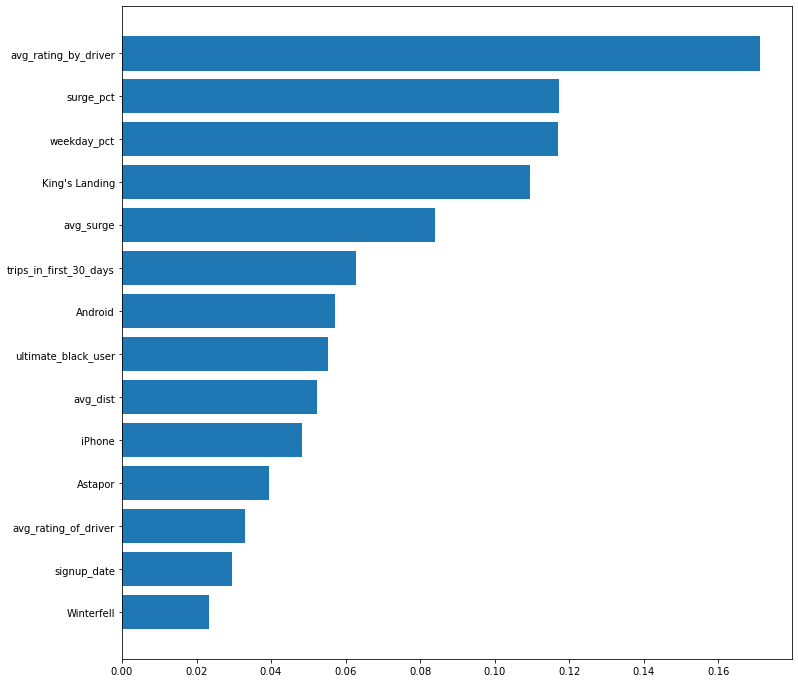

In [164]:
#plot most important features
from itertools import islice
importance=rf_fit_wv[0].feature_importances_
feat_dict=dict(zip(df.columns,importance))
sort={k: v for k, v in sorted(feat_dict.items(), reverse=False, key=lambda item: item[1])}
n_items=list(islice(sort.items(), 50))
coeffs=[round(i[1],5) for i in n_items]
indices=[i[0] for i in n_items]
plt.figure(figsize=(12,12))
plt.barh(indices, coeffs)

With a cross validated, tuned random forest model we can get a ROC-AUC score of 0.85 for predicting client retention. The most importand features that predict retention probabilities are avg_rating_by_driver (the rider’s average rating over all of their trips), surge_pct (the percent of trips taken with surge multiplier > 1), weekday_pct (the percent of the user’s trips occurring during a weekday), and when they are from Kings Landing. It seems that the main factor for rider retention is that clients are satisfied with their ride. Also they are more likely to remain customers when they are more dependent on the rides (during the weekdays, during surge hours)